# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,13146,1124,4523,1420,549,497
1,11594,7779,12144,3252,8035,3029
2,964,4984,3316,937,409,7


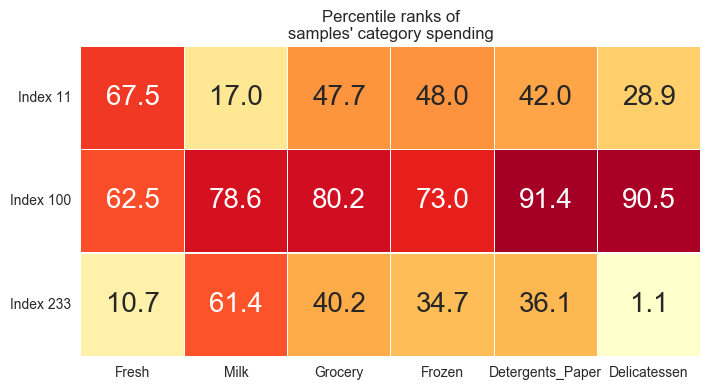

In [4]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [11,100,233]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

import matplotlib.pyplot as plt
import seaborn as sns

# look at percentile ranks
pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)

# visualize percentiles with heatmap
sns.heatmap(pcts, annot=True, annot_kws={'size':20}, linewidth=.1, vmax=99, 
            fmt='.1f', cmap='YlOrRd', square=True, cbar=False)
plt.yticks([2.5,1.5,.5], ['Index '+str(x) for x in indices], rotation='horizontal')
plt.title('Percentile ranks of\nsamples\' category spending')

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**
Customer 1 (Index 11) could be a general grocery store/supermarket with a small deli counter. Customer 1 spends a relatively high amount on Fresh and Grocery products (near 75th percentile), a moderate amount on Frozen products (near 50th percentile), and relatively fewer amounts on Milk, Detergents_Paper and Delicatessen products.

Customer 2 (Index 100) could be a hotel with a restaurant attached or inside. Customer 2 spends relatively high amounts on each category with each near or above the 75th percentile except Fresh which is about halfway between the 50th and 75th percentile.

Customer 3 (Index 233) could be a small bakery. Customer 3 spends a moderate amount on Milk (near 50th percentile), and relatively fewer amounts on Fresh, Grocery, Frozen, Detergents_Paper and Delicatessen.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [4]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Milk', axis = 1)

# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Milk'], test_size=0.25, random_state=100)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=100)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print score

0.0161148126813


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** The feature I attempted to predict is Milk. The reported prediction score is 0.016 so this feature is necessary for identifying customers' spending habits as the coefficient of determination is very, very low. The coefficient of determination is close to a score of 0.0, a score of 0.0 means that the model ignores the inputs and outputs a constant prediction irrespective of the inputs, so the combination of the other features cannot substitute for Milk.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

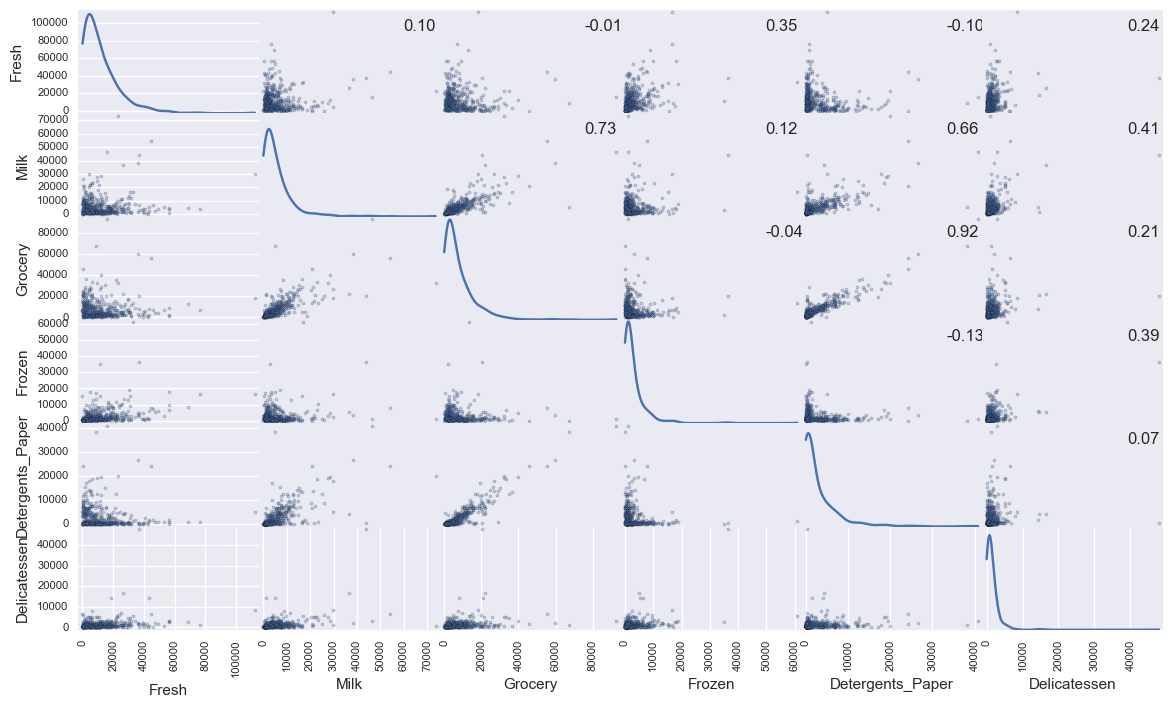

In [6]:
# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# Reformat data.corr() for plotting
corr = data.corr().as_matrix()

# Plot scatter matrix with correlations
for i,j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i,j].annotate("%.2f"%corr[i,j], (0.8,0.8), xycoords='axes fraction')

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** Milk, Grocery and Detergents_Paper show some degree of correlation with each other as the respective paired scatter plots appear to be linear. This is interesting given that the Decision Tree Regression model had such a low R^2 for Milk. Most of the points lie in the lower half of values for both features such that the mean is greater than the median.

Delicatessen also appears to be correlated with the other features with a very small range of values close for Delicatessen such that the scatter matrices appear as a line very close to the axis (which axis depends on which variable is dependent and which is independent) save for a few outliers. For Delicatessen most values are less than about 10,000 MU and for Fresh, Milk, Grocery, Frozen and Detergents_Paper most points lie in the lower half of values such that the mean is greater than the median.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

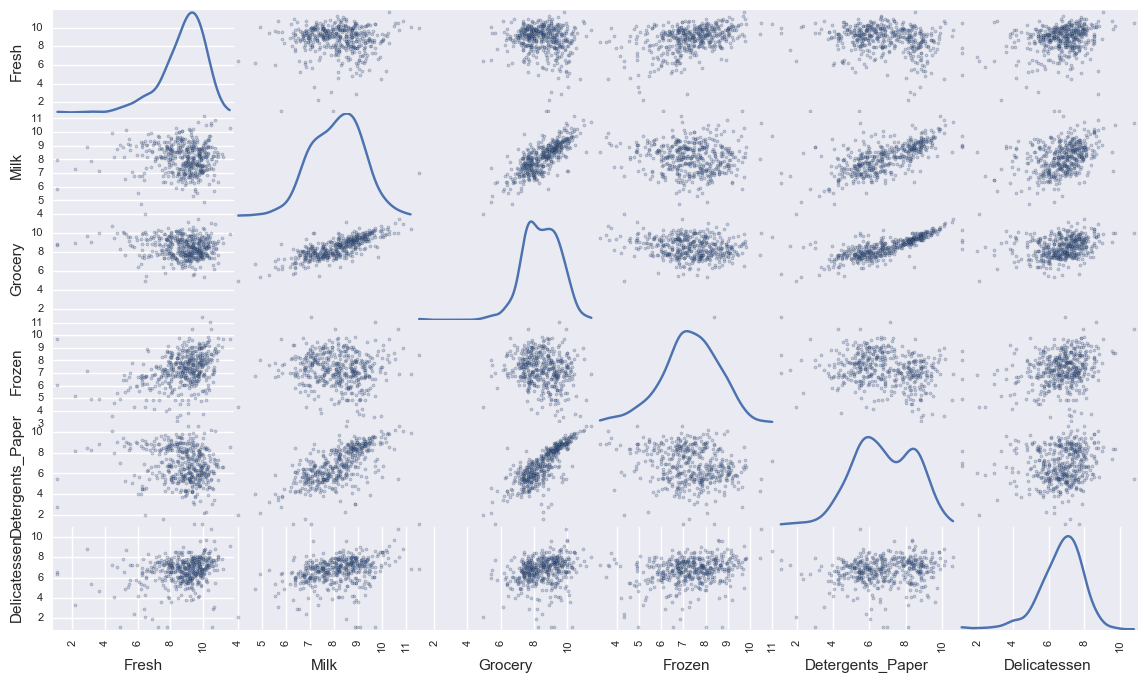

In [9]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [10]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.483873,7.024649,8.416931,7.258412,6.308098,6.208590
1,9.358243,8.959183,9.404590,8.087025,8.991562,8.015988
2,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [18]:
from collections import Counter

#initialize counter
c = Counter()

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)

    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outliers_to_count = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    c = c + Counter(outliers_to_count.index.tolist())
    display(outliers_to_count)
    
# OPTIONAL: Select the indices for data points you wish to remove
#initialize a second counter
d = Counter()
#make a key for each outlier already counted and set value to 1
for i in list(c):
    d[i] += 1

#subtract the new counter from the old to drop out keys who are outliers for only one feature
outliers  = list(c-d)

print "Data points considered outliers in more than one feature: ", outliers

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Data points considered outliers in more than one feature:  [128, 65, 154, 75, 66]


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** There are at five data points considered outliers for more than one feature: 128, 65, 154, 75, and 66. I think these data points should be removed and I added them to the outliers list because they skew the data. These customers spend a lot lower or higher than the rest of the dataset in more than one category and therefore are not representative of most customers or even outliers as most outlier data points are outliers in only a single feature.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

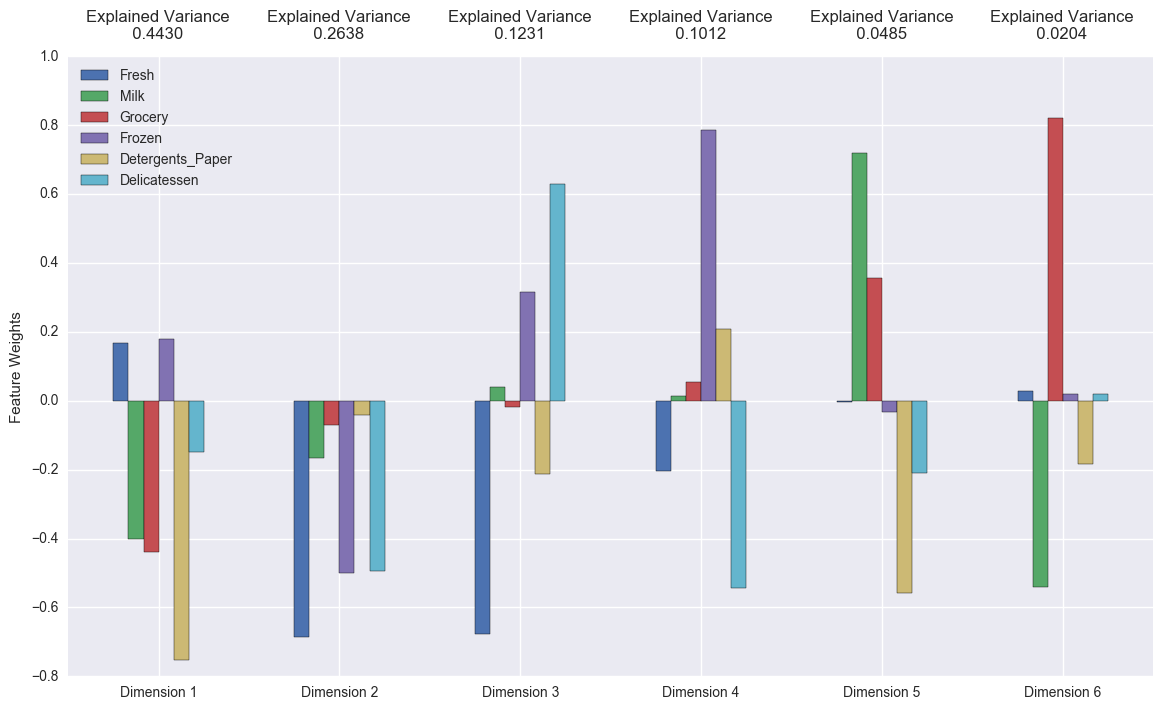

In [20]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components = 6, random_state=100)
pca.fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:** In total, the first and second principal components explain 70.68% of the variance in the data. The first four principal components explain 93.11% of the variance in the data.

The first dimension represents that Detergents_Paper, Grocery and Milk are highly correlated with each other and negatively weighted. And Frozen and Fresh have a smaller correlation and are positively weighted. An increase in this dimension represents much smaller spending on Detergents_Paper, Grocery and Milk and higher spending on Frozen and Fresh. And slightly reduced spending on Delicatessen.

The second dimension represents that Fresh, Frozen and Delicatessen are highly correlated with each other and negatively weighted. And Detergents_Paper, Grocery and Milk have a much smaller correlation and are also negatively weighted. An increase in this dimension represents much smaller spending on Fresh, Frozen and Delicatessen and slightly reduced spending on Detergents_Paper, Grocery and Milk.

The third dimension represents that Frozen and Delicatessen are highly correlated with each other and positively weighted. And Fresh has a strong weight in the negative direction. An increase in this dimension represents much higher spending on Frozen and Delicatessen, much less spending on Fresh and slightly reduced spending on Detergents_Paper. Milk sees a small positive increase and Grocery sees a small negative increase.

The fourth dimension represents that Frozen and Detergents_Paper are correlated with a strong weight in the positive direction. And Delicatessen and Fresh are correlated with a weight in the negative direction. An increase in this dimension represents much higher spending on Frozen and Detergents_Paper, much less spending on Fresh and Delicatessen and slightly increased spending on Milk and Grocery.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [21]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.0120,-0.0103,-0.7516,-0.0545,-0.4333,0.6602
1,-2.3579,-1.7393,0.2210,0.2840,-0.5939,-0.0148
2,0.8986,3.8818,-1.6638,2.4046,1.6042,-0.5143


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

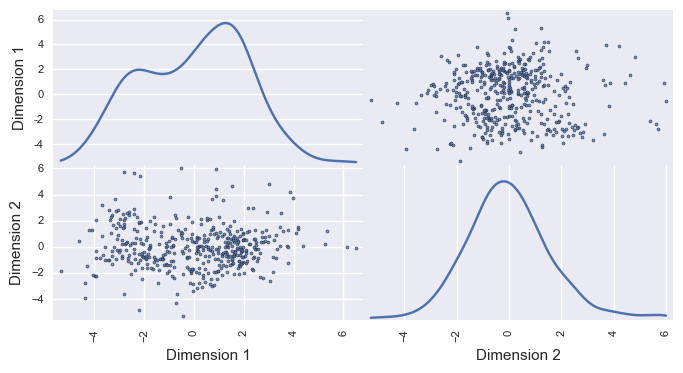

In [22]:
# TODO: Apply PCA by fitting the good data with only two dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components = 2, random_state=100)
pca = pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# Produce a scatter matrix for pca reduced data
pd.scatter_matrix(reduced_data, alpha = 0.8, figsize = (8,4), diagonal = 'kde');

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [23]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.0120,-0.0103
1,-2.3579,-1.7393
2,0.8986,3.8818


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

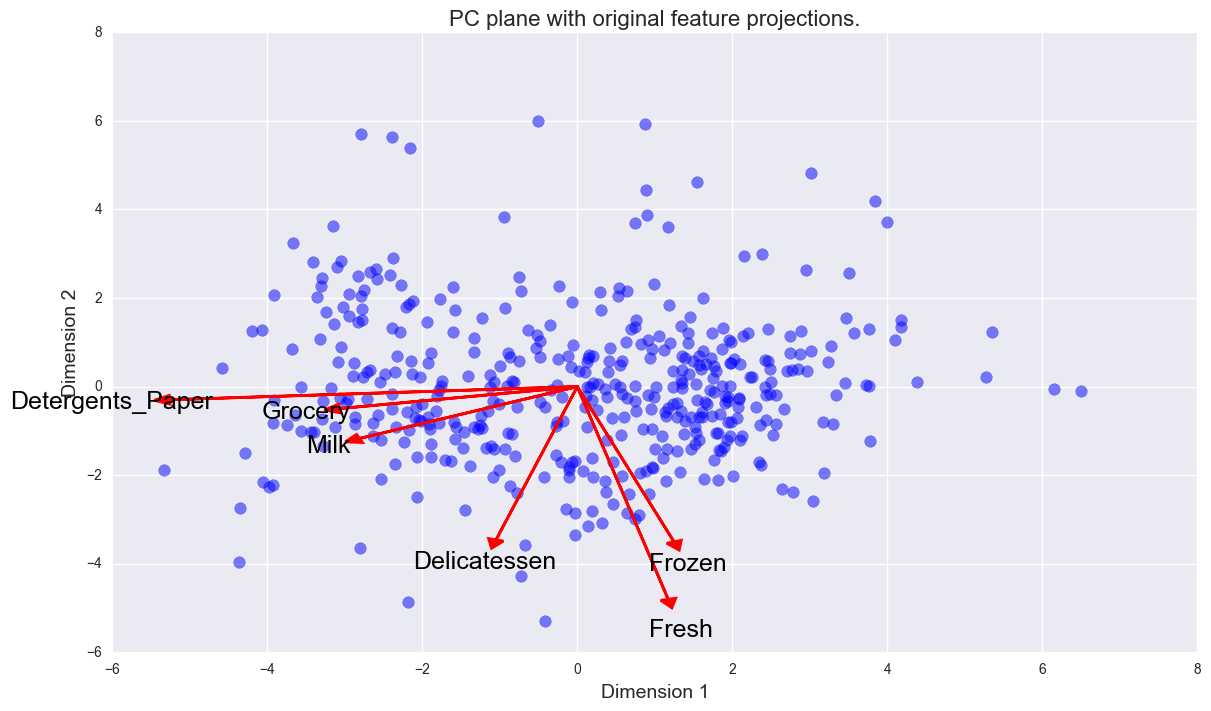

In [24]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** The advantages to using K-Means clustering are that it is fast and works well for well-defined clusters that are around the same size, and especially if the clusters are spherical.

Gaussian Mixture Model (GMM) advantage is that the clusters do not have to be well-defined, i.e. they can overlap as each point is assigned to the cluster in which it has a greatest probability of belonging to, whereas points in K-Means can only belong to one cluster. Another advantage is that GMM is not restricted by the shape of the cluster, as co-variance can vary along all dimensions within the cluster.

I will use Gaussian Mixture Model because the data does not appear to fall into well-defined clusters and there is unequal variance in the dimensions of the data as evidenced by the principal components.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [28]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
from sklearn.mixture import GaussianMixture
clusterer = GaussianMixture(n_components = 2, random_state=100).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_data, preds, random_state = 100)
print score

0.421916846463


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:** 

For 2 components, score = 0.421916846463.

For 3 components, score = 0.375532188938.

For 4 components, score = 0.345867137512.

For 5 components, score = 0.224463441465.

For 6 components, score = 0.329166536721.

For 7 components, score = 0.276431809399.

For 8 components, score = 0.262034540423.

For 9 components, score = 0.274239685321.

For 10 components, score = 0.320982836318.

2 Components had the best silhouette score.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

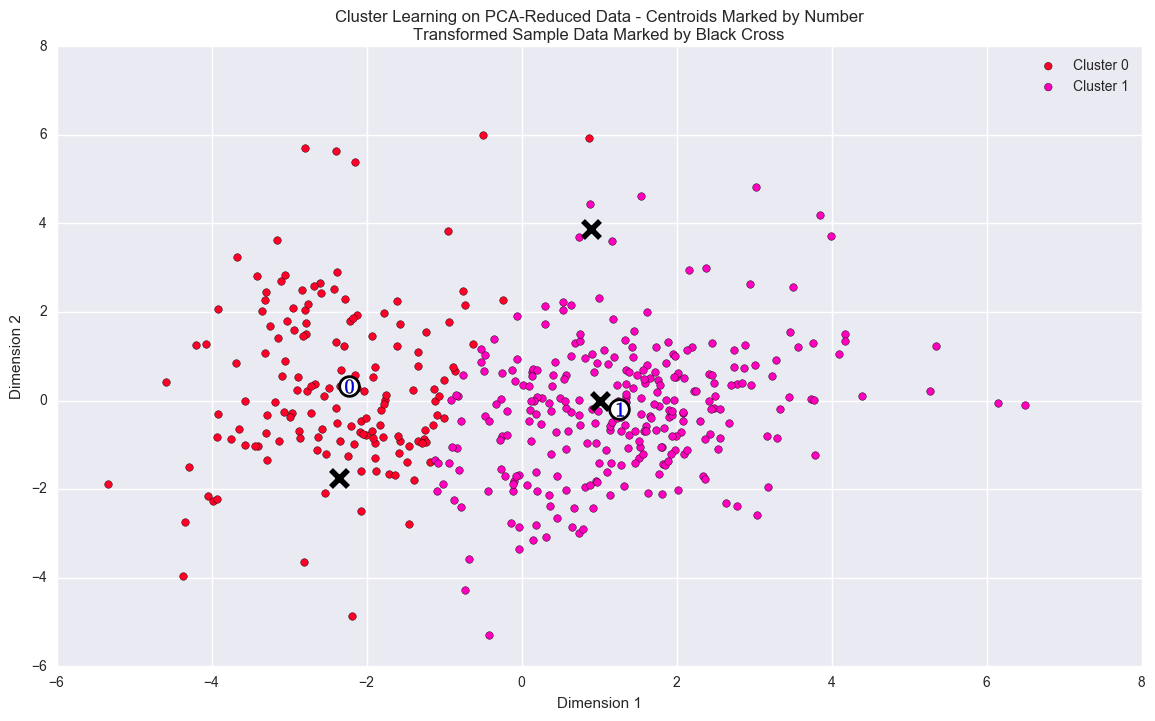

In [29]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [31]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

display(true_centers - data.mean().round())
display(true_centers - data.median().round())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3552.0,7837.0,12219.0,870.0,4696.0,962.0
Segment 1,8953.0,2114.0,2765.0,2075.0,353.0,732.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-8448.0,2041.0,4268.0,-2202.0,1815.0,-563.0
Segment 1,-3047.0,-3682.0,-5186.0,-997.0,-2528.0,-793.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-4952.0,4210.0,7463.0,-656.0,3880.0,-4.0
Segment 1,449.0,-1513.0,-1991.0,549.0,-463.0,-234.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**
- Segment 0: Grocery Stores

Relative to the mean and median of the data, Segment 0 has below average purchases of Fresh and Delicatessen, above average purchases of Milk, Grocery and Detergents_Paper and median levels of purchases for Delicatessen. Milk, Grocery and Detergents_Paper are staples for Grocery Stores so I think a customer assigned to Segment 0 would best identify with a Grocery Store.

- Segment 1: Farmers' Market

Relative to the mean and median of the data, Segment 1 has below average purchases of Milk, Grocery, Detergents_Paper and Delicatessen and above median purchases of Fresh and Frozen. Because Segment 1 spends a lot on Fresh ingredients and Frozen food and not much else, I think a customer assigned to Segment 1 would identify with a Farmers' Market.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [32]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


**Answer:** 
- Sample point 0 (Index 11) is predicted to be in the Farmers' Market cluster, Index 11 has below average purchases of Milk and Delicatessen and above average purchases of Fresh which is consistent with the segment, inconsistencies are Index 11 does spend near average on Frozen and Grocery.

- Sample point 1 (Index 100) is predicted to be in the Grocery Store cluster, Index 100 has above average purchases of Milk, Grocery and Detergents_Paper which is consistent with the segment, inconsistencies are that Index 100 does has above average purchases of Fresh and Delicatessen.

- Sample point 2 (Index 233) is predicted to be in the Farmers' Market cluster, Index 233 spends below average on Delicatessen, Grocery and Detergents_Paper. Inconsistencies are that Index 233 spends below avergae on Fresh and Frozen and above average on Milk.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:** We cannot assume the change affects all customers equally. We can determine which group of customers will be the most affected by running the A/B test within each customer segment separately with one control and one variation group per ssegment. The segment with the most negative reaction within the variation group will be the segment most negatively affected. We will also be able to see if any variation groups react positively to the change.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:** We can use the pca model to add the customer_segment engineered feature to the data. Using the customer_segment variable as the target, we can fit a classifcation model using the data. Once the model is fitted, we can use it to predict the customer_segment for the ten new customers based on their estimated product spending.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

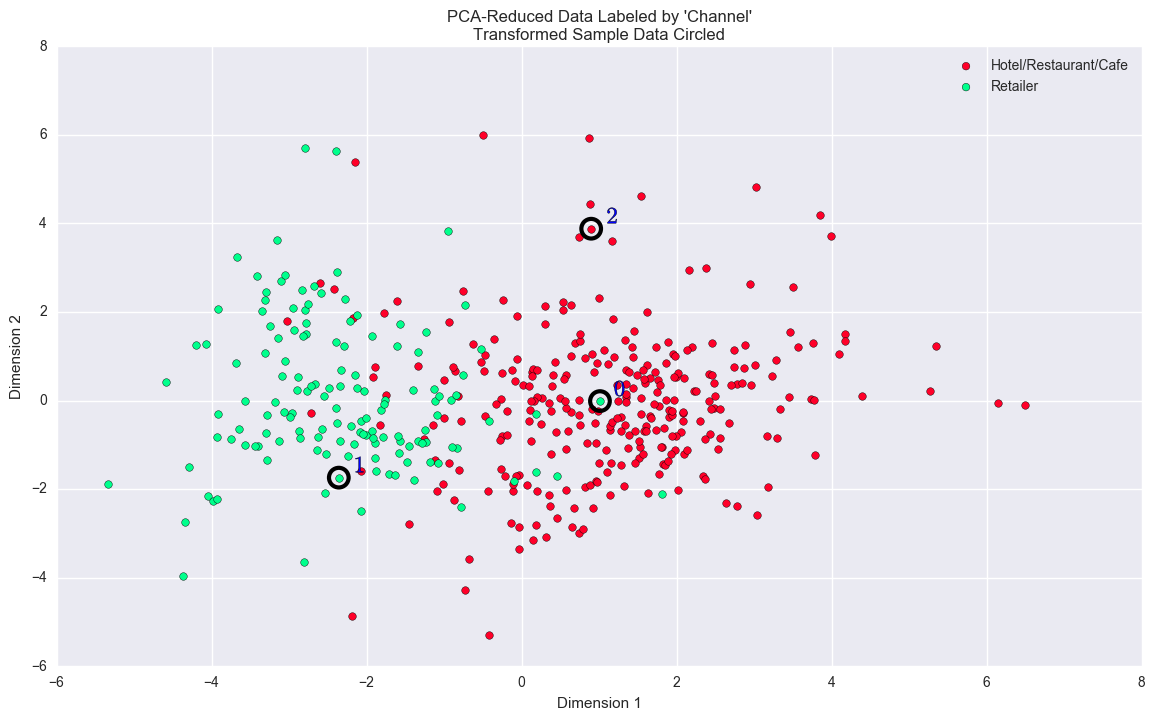

In [33]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:** The clustering algorithm and number of clusters I've chosen compares pretty well. Clusters 0 and 1 from my algorithm cluster into somewhat similar groups as the Hotel/Restaurant/Cafe and Retailer distributions. However, the clusters from the algorithm have no overlap unlike the Hotel/Restaurant/Cafe and Retailer distributions which feature many outliers. I think these classifications are mostly consistent with the customer segments that I defined, and most differences are accounted for by the strict boundaries between the algorithmically-defined clusters.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.